# Cubic Bezier Optimization

Optimizes a cubic bezier curved-line path from a point on the viable brain surface region to a point on the subthalamic nucleus (STN) for DBS electrode planning.

Treats the following as obstacles:
- Sulci
- Ventricles
- Corpus Callosum (prevent brain crossing)

**Objective Functions**
- Distance to obstacles
- Minimum path distance  *(not optimized yet)*

## 1. Setup

### Import Libraries

In [2]:
import os
import glob
import random
import numpy as np
import pandas as pd

import vedo
from vedo import Volume, show, Line, merge, Plotter, Points

from scipy.optimize import minimize

import k3d

In [3]:
# Set vedo backend to pop out plots in separate windows
vedo.settings.default_backend = '2d' # or 'vt' or '2d' or 'k3d' or 'ipyvtklink'

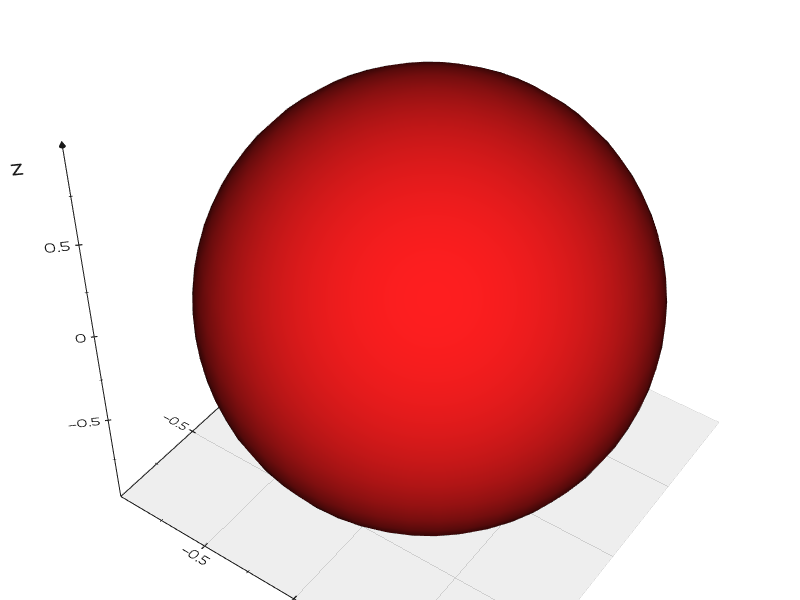

In [4]:
## Vedo sphere plot test
sphere = vedo.Sphere(pos=[0, 0, 0], c="red", r=1.0)
plotter = vedo.Plotter()
plotter += sphere
plotter.show(axes=1, viewup='z', zoom=1.5)


### Configuration and Setup

In [5]:
# Define new base directory and sub-folder structure
base_dir = "./FINAL_BRAIN_ATLAS/final_nii_files"

# Entry zones (viable surface regions for path start)
entry_zone_dir = os.path.join(base_dir, "entry_zone")
left_entry_zone_dir = os.path.join(entry_zone_dir, "LEFT_ENTRY_ZONE")
right_entry_zone_dir = os.path.join(entry_zone_dir, "RIGHT_ENTRY_ZONE")

# Subthalamic nucleus (targets)
stn_root_dir = os.path.join(base_dir, "subthalamic_nucleus")
left_stn_dir = os.path.join(stn_root_dir, "LEFT_STN")
right_stn_dir = os.path.join(stn_root_dir, "RIGHT_STN")

# Full brain (for context / outline only)
full_brain_dir = os.path.join(base_dir, "full_brain")

# Obstacles (same role as before)
obstacles_dir = os.path.join(base_dir, "obstacles")

print("Base directory:", base_dir)


Base directory: ./FINAL_BRAIN_ATLAS/final_nii_files


### Load Brain Structures

Recursively load all `.nii` / `.nii.gz` files under each designated root:
- Entry Zones (LEFT/RIGHT) viable start regions (light brown, low alpha)
- STN Targets (LEFT/RIGHT) (distinct greens)
- Obstacles (red)
- Full Brain outline (very light grey, minimal alpha)

All subfolder contents are merged later per category.

In [6]:
# Initialize lists for different structure types
left_entry_zone_structures = []
right_entry_zone_structures = []
left_stn_structures = []
right_stn_structures = []
allowed_left_entry_zone_structures = []
allowed_right_entry_zone_structures = []
obstacle_structures = []
full_brain_structures = []

# Loader utility: walk all subfolders and load every .nii / .nii.gz
def load_folder_surfaces(root_folder, color, alpha=1.0):
    loaded = []
    if not os.path.isdir(root_folder):
        print(f"[WARN] Folder not found: {root_folder}")
        return loaded
    
    for dirpath, dirnames, filenames in os.walk(root_folder):
        nii_files = [f for f in filenames if f.lower().endswith('.nii') or f.lower().endswith('.nii.gz')]
        for fname in nii_files:
            fpath = os.path.join(dirpath, fname)
            rel = os.path.relpath(fpath, root_folder)
            print(f"  Loading structure: {rel}")
            try:
                vol = Volume(fpath)
                surf = vol.isosurface()
                surf.c(color).alpha(alpha)
                loaded.append(surf)
            except Exception as e:
                print(f"  [WARN] Failed to load volume/surface: {fpath} ({e})")
    if not loaded:
        print(f"  [INFO] No NIfTI files found under {root_folder}")
    return loaded

print("\nLoading Entry Zones (LEFT)...")
left_entry_zone_structures = load_folder_surfaces(left_entry_zone_dir, color=(0.95, 0.65, 0.85), alpha=0.04)
print("Loading Entry Zones (RIGHT)...")
right_entry_zone_structures = load_folder_surfaces(right_entry_zone_dir, color=(0.95, 0.75, 0.85), alpha=0.04)

# STN folders (may already be deepest; recursion still safe)
print("\nLoading STN (LEFT)...")
left_stn_structures = load_folder_surfaces(left_stn_dir, color="green", alpha=1.0)
print("Loading STN (RIGHT)...")
right_stn_structures = load_folder_surfaces(right_stn_dir, color="green", alpha=1.0)

print("\nLoading Obstacles...")
obstacle_structures = load_folder_surfaces(obstacles_dir, color="red", alpha=0.7)

print("\nLoading Full Brain Outline...")
full_brain_structures = load_folder_surfaces(full_brain_dir, color="grey", alpha=0.01)



Loading Entry Zones (LEFT)...
  Loading structure: LEFT_FRONTAL_LOBE\Model_1003_posterior_part_of_left_middle_frontal_gyrus.nii
  Loading structure: LEFT_FRONTAL_LOBE\Model_1012_left_lateral_orbital_gyrus.nii
  Loading structure: LEFT_FRONTAL_LOBE\Model_1014_left_straight_gyrus.nii
  Loading structure: LEFT_FRONTAL_LOBE\Model_1017_left_paracentral_lobule.nii
  Loading structure: LEFT_FRONTAL_LOBE\Model_1018_opercular_part_of_left_inferior_frontal_gyrus.nii
  Loading structure: LEFT_FRONTAL_LOBE\Model_1019_orbital_part_of_left_inferior_frontal_gyrus.nii
  Loading structure: LEFT_FRONTAL_LOBE\Model_1020_triangular_part_of_left_inferior_frontal_gyrus.nii
  Loading structure: LEFT_FRONTAL_LOBE\Model_1024_left_precentral_gyrus.nii
  Loading structure: LEFT_FRONTAL_LOBE\Model_1027_anterior_part_of_left_middle_frontal_gyrus.nii
  Loading structure: LEFT_FRONTAL_LOBE\Model_1028_left_superior_frontal_gyrus.nii
  Loading structure: LEFT_FRONTAL_LOBE\Model_1032_left_frontal_pole.nii
  Loading st

### Merge Structures

Combine individual structures into single meshes for:
- LEFT/RIGHT Entry Zones (start sampling)
- LEFT/RIGHT STN (target sampling hemisphere-consistent)
- Obstacles (for intersection & distance)
- Full Brain (context outline only)


In [8]:
# Merge structures into single meshes
merged_left_entry_zone = merge(left_entry_zone_structures) if left_entry_zone_structures else None
if merged_left_entry_zone: merged_left_entry_zone.alpha(0.04)

merged_right_entry_zone = merge(right_entry_zone_structures) if right_entry_zone_structures else None
if merged_right_entry_zone: merged_right_entry_zone.alpha(0.04)

# Placeholders for allowed (outer-facing) entry zone meshes; computed later
merged_allowed_left_entry_zone = None
merged_allowed_right_entry_zone = None

merged_left_stn = merge(left_stn_structures) if left_stn_structures else None
merged_right_stn = merge(right_stn_structures) if right_stn_structures else None

merged_obstacles = merge(obstacle_structures) if obstacle_structures else None
if merged_obstacles: merged_obstacles.c("red").alpha(0.75)

merged_full_brain = merge(full_brain_structures) if full_brain_structures else None
if merged_full_brain: merged_full_brain.c("grey").alpha(0.01)

print("\nMerged Summary:")
print(f"  Left Entry Zone: {'yes' if merged_left_entry_zone else 'no'}")
print(f"  Right Entry Zone: {'yes' if merged_right_entry_zone else 'no'}")
print(f"  Left Allowed Entry Zone: {'yes' if merged_allowed_left_entry_zone else 'no'}")
print(f"  Right Allowed Entry Zone: {'yes' if merged_allowed_right_entry_zone else 'no'}")
print(f"  Left STN: {'yes' if merged_left_stn else 'no'}")
print(f"  Right STN: {'yes' if merged_right_stn else 'no'}")
print(f"  Obstacles: {'yes' if merged_obstacles else 'no'}")
print(f"  Full Brain: {'yes' if merged_full_brain else 'no'}")



Merged Summary:
  Left Entry Zone: yes
  Right Entry Zone: yes
  Left Allowed Entry Zone: no
  Right Allowed Entry Zone: no
  Left STN: yes
  Right STN: yes
  Obstacles: yes
  Full Brain: yes


In [9]:
# Compute allowed entry zones (outer-facing only) based on full brain center
# This cell should run AFTER merging meshes
if merged_full_brain is None:
    print("[WARN] Full brain mesh not available; cannot compute outward-facing entry zones.")
else:
    brain_center = np.array(merged_full_brain.points).mean(axis=0)
    
    allowed_left_entry_zone_structures = []
    allowed_right_entry_zone_structures = []
    
    def outer_facing_mesh_from_merged(merged_mesh, color, alpha):
        if merged_mesh is None:
            return None
        # Ensure normals on cells
        merged_mesh.compute_normals(points=False, cells=True, consistency=True)
        verts = np.array(merged_mesh.points)
        faces = np.array(merged_mesh.cells)
        try:
            norms = np.array(merged_mesh.celldata["Normals"])
        except Exception:
            norms = None
        if norms is None or norms.size == 0 or faces.size == 0:
            print("  [WARN] Could not compute cell normals; returning original merged mesh")
            mm = merged_mesh.clone()
            mm.c(color).alpha(alpha)
            return mm
        faces_centers = verts[faces].mean(axis=1)
        vectors = faces_centers - brain_center
        dots = np.einsum("ij,ij->i", norms, vectors)
        keep = dots > 0
        if keep.sum() == 0:
            print("  [WARN] No outward-facing faces detected; returning original merged mesh")
            mm = merged_mesh.clone()
            mm.c(color).alpha(alpha)
            return mm
        outer_faces = faces[keep]
        outer_mesh = vedo.Mesh([verts, outer_faces])
        outer_mesh.clean()
        outer_mesh.smooth()
        outer_mesh.c(color).alpha(alpha)
        return outer_mesh
    
    # Compute allowed (outer-facing) merged entry zone meshes
    merged_allowed_left_entry_zone = outer_facing_mesh_from_merged(merged_left_entry_zone, color=(0.95, 0.65, 0.85), alpha=0.04)
    merged_allowed_right_entry_zone = outer_facing_mesh_from_merged(merged_right_entry_zone, color=(0.95, 0.75, 0.85), alpha=0.04)
    
    # Also keep list variants for downstream plotting that expects lists
    if merged_allowed_left_entry_zone is not None:
        allowed_left_entry_zone_structures = [merged_allowed_left_entry_zone]
    if merged_allowed_right_entry_zone is not None:
        allowed_right_entry_zone_structures = [merged_allowed_right_entry_zone]
    
    print("Computed outward-facing allowed entry zone meshes using full brain center.")

Computed outward-facing allowed entry zone meshes using full brain center.


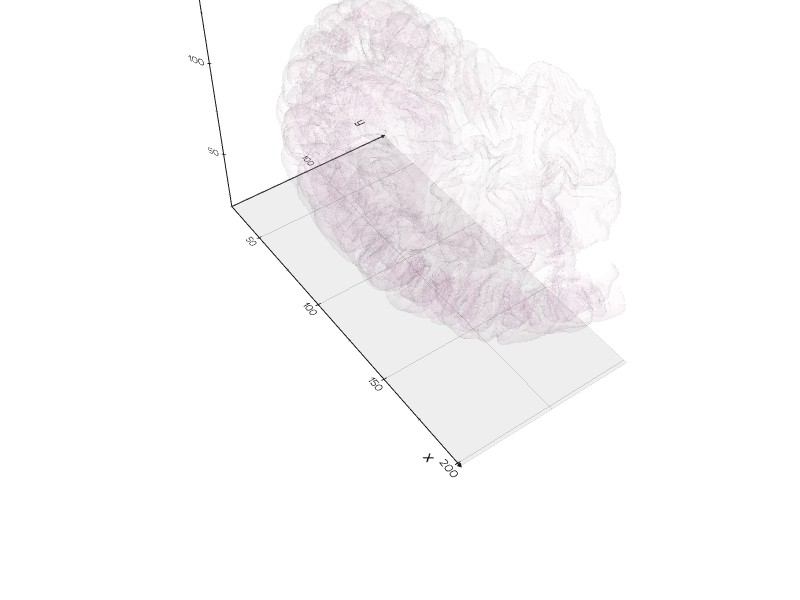

In [10]:
# Plot and show the outer entry zone
actors1 = []
actors1 += allowed_left_entry_zone_structures
actors1 += allowed_right_entry_zone_structures
# actors1.append(merged_full_brain)
show(actors1, axes=1, viewup="z", title="Entry Zones")


### Helper Functions

In [11]:
def compute_path_length(start_point, end_point):
    """Compute the distance between two points for the line path."""
    return np.linalg.norm(np.array(end_point) - np.array(start_point))


def compute_obstacle_distance(start_point, end_point):
    """Compute the minimum distance from the line path to any obstacle."""
    if merged_obstacles is None:
        return 0.0
    temp_line = Line([start_point, end_point])
    d = temp_line.distance_to(merged_obstacles)
    if isinstance(d, (list, tuple, np.ndarray)):
        return float(np.min(d))
    return float(d)


def check_intersection(start_point, end_point):
    """Check if the line path intersects any obstacle."""
    if merged_obstacles is None:
        return False
    intersections = merged_obstacles.intersect_with_line(start_point, end_point)
    return intersections is not None and len(intersections) > 0


def _closest_point_on_mesh(point, mesh):
    """Project a 3D point onto the closest point on a mesh surface."""
    if mesh is None:
        return tuple(point)
    try:
        cp = mesh.closest_point(point)
        return tuple(cp)
    except Exception:
        # Fallback to nearest vertex
        verts = np.asarray(mesh.vertices)
        if verts.size == 0:
            return tuple(point)
        idx = int(np.argmin(np.linalg.norm(verts - np.asarray(point), axis=1)))
        return tuple(verts[idx])


def project_to_surfaces(start_point, end_point, hemisphere):
    """Project start/end onto entry zone and STN surfaces for the chosen hemisphere."""
    if hemisphere == 'left':
        sp = _closest_point_on_mesh(start_point, merged_allowed_left_entry_zone)
        ep = _closest_point_on_mesh(end_point, merged_left_stn)
    else:
        sp = _closest_point_on_mesh(start_point, merged_allowed_right_entry_zone)
        ep = _closest_point_on_mesh(end_point, merged_right_stn)
    return sp, ep


def sample_start_and_end():
    """Sample a hemisphere-consistent start (entry zone) and end (STN)."""
    hemispheres = []
    if merged_allowed_left_entry_zone and merged_left_stn:
        hemispheres.append('left')
    if merged_allowed_right_entry_zone and merged_right_stn:
        hemispheres.append('right')
    if not hemispheres:
        raise RuntimeError("No valid hemisphere data available for sampling.")
    hemi = random.choice(hemispheres)
    if hemi == 'left':
        start = tuple(merged_allowed_left_entry_zone.generate_random_points(1).points[0])
        end = tuple(merged_left_stn.generate_random_points(1).points[0])
    else:
        start = tuple(merged_allowed_right_entry_zone.generate_random_points(1).points[0])
        end = tuple(merged_right_stn.generate_random_points(1).points[0])
    return hemi, start, end


## Cubic Bezier Function


### Helper Functions

In [12]:
def propose_control_points(start, end):
    start = np.array(start)
    end = np.array(end)
    d = end - start
    d_norm = d / np.linalg.norm(d)

    # perpendicular vector
    tmp = np.random.randn(3)
    perp = tmp - np.dot(tmp, d_norm)*d_norm
    perp /= np.linalg.norm(perp)

    alpha = np.random.uniform(0.1, 0.4)
    gamma = np.random.uniform(0.6, 0.9)
    beta = np.random.uniform(0, 25.0)  # mm

    P1 = start + alpha * d + beta * perp
    P2 = start + gamma * d - beta * perp

    return P1, P2

def sample_bezier_points(start_point, control_point1, control_point2, end_point, num_samples=100):
    # sample points along 3d cubic bezier curve
    P0 = np.asarray(start_point, dtype=float)
    P1 = np.asarray(control_point1, dtype=float)
    P2 = np.asarray(control_point2, dtype=float)
    P3 = np.asarray(end_point, dtype=float)

    t = np.linspace(0.0, 1.0, num_samples)
    one_minus_t = 1.0 - t

    pts = (
        (one_minus_t**3)[:, None] * P0 +
        (3 * one_minus_t**2 * t)[:, None] * P1 +
        (3 * one_minus_t * t**2)[:, None] * P2 +
        (t**3)[:, None] * P3
    )
    return pts

def compute_obstacle_distance_bezier(start_point, end_point, control_point1, control_point2, num_samples=100):
    # calculate the minimum distance from the cubic bezier path to any obstacle
    if merged_obstacles is None:
        return 0.0

    pts = sample_bezier_points(start_point, control_point1, control_point2, end_point, num_samples=num_samples)
    curve_pts = Points(pts)

    d = curve_pts.distance_to(merged_obstacles)
    if isinstance(d, (list, tuple, np.ndarray)):
        return float(np.min(d))
    return float(d)

def check_intersection_bezier(start_point, end_point, control_point1, control_point2, num_samples=100):
    """
    1. check if the cubic bezier path intersects any obstacle, and
    2. approximates curve with short line segments and tests each segment.
    """
    if merged_obstacles is None:
        return False

    pts = sample_bezier_points(start_point, control_point1, control_point2, end_point, num_samples=num_samples)

    # check each segment along the curve
    for i in range(len(pts) - 1):
        p0 = pts[i]
        p1 = pts[i + 1]
        intersections = merged_obstacles.intersect_with_line(p0, p1)
        if intersections is not None and len(intersections) > 0:
            return True

    return False


### Create Bezier Path and Compute Length

In [13]:
def compute_bezier_path_length(
    start_point,
    end_point,
    control_point1,
    control_point2,
    min_radius_mm=None,
    num_samples=1000,
):
    """
    compute length of 3d cubic bezeier curve btw start_point and end_point

    calculate p1 p2 from propose_control_points helper function

    """
    P0 = np.asarray(start_point, dtype=float)
    P1 = np.asarray(control_point1, dtype=float)
    P2 = np.asarray(control_point2, dtype=float)
    P3 = np.asarray(end_point, dtype=float)

    t = np.linspace(0.0, 1.0, num_samples)

    def bezier_pos(t):
        one_minus_t = 1.0 - t
        return (
            (one_minus_t**3)[:, None] * P0 +
            (3 * one_minus_t**2 * t)[:, None] * P1 +
            (3 * one_minus_t * t**2)[:, None] * P2 +
            (t**3)[:, None] * P3
        )

    # first derivative B'(t)
    def bezier_first_derivative(t):
        one_minus_t = 1.0 - t
        return (
            (3 * one_minus_t**2)[:, None] * (P1 - P0) +
            (6 * one_minus_t * t)[:, None] * (P2 - P1) +
            (3 * t**2)[:, None] * (P3 - P2)
        )

    # secibd derivative B''(t)
    def bezier_second_derivative(t):
        return (
            (6 * (1.0 - t))[:, None] * (P2 - 2*P1 + P0) +
            (6 * t)[:, None] * (P3 - 2*P2 + P1)
        )

    pts = bezier_pos(t) #sample curve

    # approx. length
    diffs = np.diff(pts, axis=0)
    segment_lengths = np.linalg.norm(diffs, axis=1)
    length = float(np.sum(segment_lengths))

    # electrode needle curvature constraint
    if min_radius_mm is not None:
        t_mid = t[1:-1]
        B1 = bezier_first_derivative(t_mid)
        B2 = bezier_second_derivative(t_mid)

        # curvature k(t) = ||B'(t) x B''(t)|| / ||B'(t)||^3
        cross = np.cross(B1, B2)
        num = np.linalg.norm(cross, axis=1)
        denom = np.linalg.norm(B1, axis=1)**3

        with np.errstate(divide='ignore', invalid='ignore'):
            curvature = np.where(denom > 0, num / denom, 0.0)

        # radius of curvature R(t) = 1 / k(t) --> if straight, R(t) = inf
        radius = np.where(curvature > 0, 1.0 / curvature, np.inf)

        min_radius_on_curve = np.min(radius)

        if min_radius_on_curve < min_radius_mm:
            print(f"Curvature constraint violated: minimum radius along curve ")
            print(f"is {min_radius_on_curve:.3f} mm, required >= {min_radius_mm:.3f} mm.")
            return None 

    return length



## 2. Monte Carlo Optimization

### Path Generation and Optimization

Generate random paths from brain surface to STN and evaluate them:
- **Orange lines**: Failed paths (intersect obstacles)
- **Yellow lines**: Successful but suboptimal paths
- **Green line**: Optimal path (maximum distance from obstacles)

**Optimization Algorithm**

Runs until finding a successful path and after a minimum of `min_attempts`.

Chooses a **random location** from the viable brain surface region and the STN of the corresponding hemisphere. 

For each plot, the distance from obstacles is saved. The "best" path is determined using the highest distance to obstacles.

In [21]:
# Configuration for Monte Carlo path generation
max_attempts = 1000
min_attempts = 500
successful_attempts = []  # Store (hemisphere, start_point, end_point, control_point1, control_point2, obstacle_distance, path_length) tuples
failed_attempts = []      # Store (hemisphere, start_point, end_point, control_point1, control_point2, obstacle_distance(=0 for fail), path_length)
failed_lines = []

# Line width configuration (for visualization)
BEST_PATH_WIDTH = 8
SUBOPTIMAL_PATH_WIDTH = 5
FAILED_PATH_WIDTH = 5

# Curvature constraint
R_MIN_MM = 40.0  # min radius of curvature

In [22]:
# Generate and evaluate hemisphere-consistent bezier paths
for attempt in range(max_attempts):
    if attempt + 1 > min_attempts:
        break

    hemi, start_point, end_point = sample_start_and_end()
    print(f"Attempt {attempt+1}: hemisphere={hemi} start={start_point} end={end_point}")

    # Generate control points for cubic bezier curve
    P1, P2 = propose_control_points(start_point, end_point)
    
    # Compute path length with curvature constraint
    path_len = compute_bezier_path_length(
        start_point=start_point,
        end_point=end_point,
        control_point1=P1,
        control_point2=P2,
        min_radius_mm=R_MIN_MM,
    )
    
    if path_len is None:  # skip paths that violate curvature (too sharp bend)
        print(f"  Skipping path: violates curvature constraint")
        continue

    # Check for intersection if we have obstacles
    if merged_obstacles:
        if not check_intersection_bezier(start_point, end_point, P1, P2, num_samples=100):
            # Compute metrics
            obstacle_dist = compute_obstacle_distance_bezier(start_point, end_point, P1, P2)
            successful_attempts.append((hemi, start_point, end_point, P1, P2, obstacle_dist, path_len))
            print(f"  SUCCESS - Obstacle Distance: {obstacle_dist:.3f} Path Length: {path_len:.3f}")
        else:
            pts = sample_bezier_points(start_point, P1, P2, end_point, num_samples=100)
            failed_line = Line(pts).c("orange").alpha(0.3).lw(FAILED_PATH_WIDTH)
            failed_lines.append(failed_line)
            failed_attempts.append((hemi, start_point, end_point, P1, P2, 0.0, path_len))
            print("  FAIL - Curve intersects obstacles")
    else:
        obstacle_dist = 0.0
        successful_attempts.append((hemi, start_point, end_point, P1, P2, obstacle_dist, path_len))
        print(f"  SUCCESS (no obstacles) Path Length: {path_len:.3f}")
else:
    print(f"Warning: Only found {len(successful_attempts)} non-intersecting curves after {max_attempts} attempts")

Attempt 1: hemisphere=right start=(np.float32(132.18024), np.float32(86.47253), np.float32(112.66125)) end=(np.float32(108.51828), np.float32(129.25), np.float32(85.323166))
Curvature constraint violated: minimum radius along curve 
is 34.407 mm, required >= 40.000 mm.
  Skipping path: violates curvature constraint
Attempt 2: hemisphere=left start=(np.float32(47.701977), np.float32(131.72037), np.float32(64.96315)) end=(np.float32(108.42573), np.float32(130.0), np.float32(72.878365))
Curvature constraint violated: minimum radius along curve 
is 13.531 mm, required >= 40.000 mm.
  Skipping path: violates curvature constraint
Attempt 3: hemisphere=left start=(np.float32(41.505917), np.float32(88.68398), np.float32(68.40795)) end=(np.float32(107.23909), np.float32(132.48909), np.float32(72.86038))
Curvature constraint violated: minimum radius along curve 
is 8.700 mm, required >= 40.000 mm.
  Skipping path: violates curvature constraint
Attempt 4: hemisphere=right start=(np.float32(165.90

### Select Optimal Path

Find the best path among successful attempts by maximizing distance from obstacles.

In [24]:
# Select best path (maximum obstacle distance; tie-breaker shorter path length)
best_path = None
suboptimal_lines = []
selected_hemisphere = None

if successful_attempts:
    # Sort: first by obstacle distance desc, then by path length asc
    successful_attempts.sort(key=lambda x: (-x[5], x[6]))

    best_hemi, best_start, best_end, best_P1, best_P2, best_obstacle_dist, best_path_len = successful_attempts[0]
    best_pts = sample_bezier_points(best_start, best_P1, best_P2, best_end, num_samples=100)
    best_path = Line(best_pts).c("green").lw(BEST_PATH_WIDTH)
    selected_hemisphere = best_hemi
    print(f"\nBest path: hemisphere={best_hemi} obstacle_dist={best_obstacle_dist:.3f} path_len={best_path_len:.3f}")

    max_suboptimal_paths = 10
    s = 1
    for hemi, start_pt, end_pt, P1, P2, obstacle_dist, path_len in successful_attempts[1:]:
        if s > max_suboptimal_paths:
            break
        
        pts = sample_bezier_points(start_pt, P1, P2, end_pt, num_samples=100)
        suboptimal_line = Line(pts).c("yellow").alpha(0.3).lw(SUBOPTIMAL_PATH_WIDTH)
        suboptimal_lines.append(suboptimal_line)
        print(f"Suboptimal path {s}: hemi={hemi} obstacle_dist={obstacle_dist:.3f} path_len={path_len:.3f}")
        
        s += 1
else:
    print("No successful paths found!")

print("\nTotal successful paths: ", len(successful_attempts))



Best path: hemisphere=right obstacle_dist=7.427 path_len=43.135
Suboptimal path 1: hemi=right obstacle_dist=6.665 path_len=68.730
Suboptimal path 2: hemi=right obstacle_dist=5.665 path_len=70.679
Suboptimal path 3: hemi=right obstacle_dist=4.453 path_len=75.142
Suboptimal path 4: hemi=left obstacle_dist=4.393 path_len=56.619
Suboptimal path 5: hemi=left obstacle_dist=4.310 path_len=66.514
Suboptimal path 6: hemi=right obstacle_dist=4.044 path_len=80.888
Suboptimal path 7: hemi=left obstacle_dist=3.763 path_len=42.440
Suboptimal path 8: hemi=left obstacle_dist=3.533 path_len=74.049
Suboptimal path 9: hemi=left obstacle_dist=3.478 path_len=40.768
Suboptimal path 10: hemi=right obstacle_dist=3.230 path_len=57.006

Total successful paths:  31


In [25]:
## Save Monte Carlo bezier path coordinates to file (success + fail + best flag)
output_file = "monte_carlo_bezier_paths.csv"
with open(output_file, 'w') as f:
    f.write("hemisphere,start_x,start_y,start_z,end_x,end_y,end_z,p1_x,p1_y,p1_z,p2_x,p2_y,p2_z,obstacle_distance,path_length,status,is_best\n")
    # Successful attempts are already sorted (best first) after selection step
    for idx, (hemi, start_pt, end_pt, P1, P2, obstacle_dist, path_len) in enumerate(successful_attempts):
        is_best = 1 if idx == 0 else 0
        f.write(
            f"{hemi},{start_pt[0]},{start_pt[1]},{start_pt[2]},{end_pt[0]},{end_pt[1]},{end_pt[2]},{P1[0]},{P1[1]},{P1[2]},{P2[0]},{P2[1]},{P2[2]},{obstacle_dist},{path_len},success,{is_best}\n"
        )
    # Failed attempts
    for hemi, start_pt, end_pt, P1, P2, obstacle_dist, path_len in failed_attempts:
        f.write(
            f"{hemi},{start_pt[0]},{start_pt[1]},{start_pt[2]},{end_pt[0]},{end_pt[1]},{end_pt[2]},{P1[0]},{P1[1]},{P1[2]},{P2[0]},{P2[1]},{P2[2]},{obstacle_dist},{path_len},fail,0\n"
        )
print(f"Saved Monte Carlo bezier paths ({len(successful_attempts)} success, {len(failed_attempts)} fail) to {output_file}")

Saved Monte Carlo bezier paths (31 success, 20 fail) to monte_carlo_bezier_paths.csv


## 3. Weighted Sum + Nelder-Mead Optimization

### Configuration

Set weights and optimization parameters:
- `w_obstacle`: Weight for obstacle distance (maximize)
- `w_path_length`: Weight for path length (minimize)
- Weights are normalized automatically

In [26]:
# Weights for multi-objective optimization (easily configurable)
w_obstacle = 0.9     # Weight for obstacle distance (higher = prefer safer paths)
w_path_length = 0.1   # Weight for path length (higher = prefer shorter paths)

# Normalize weights to sum to 1
total_weight = w_obstacle + w_path_length
w_obstacle_norm = w_obstacle / total_weight
w_path_length_norm = w_path_length / total_weight

print(f"Objective function weights:\n  Obstacle distance: {w_obstacle_norm:.3f}\n  Path length: {w_path_length_norm:.3f}")

# Nelder-Mead parameters
initial_point_attempts = 50
nm_max_iterations = 5000
nm_tolerance = 1e-6  # default: 1e-6, applied as xatol and fatol

# Hemisphere lock for optimization (set later when picking x0)
nm_hemisphere = None

Objective function weights:
  Obstacle distance: 0.900
  Path length: 0.100


### Weighted Sum Objective Function

Combines both objectives (obstacle distance and path length) into a single scalar value for optimization.

In [27]:
# Global variables for normalization (will be computed from sample paths)
max_obstacle_dist = None
max_path_length = None

last_eval = {
    "x": None,
    "start": None,
    "end": None,
    "P1": None,
    "P2": None,
    "path_points": None,
    "objective": None,
}

all_evals = []

def weighted_sum_objective(x):
    """
    Weighted sum objective function for cubic bezier optimization.

    Parameters:
    -----------
    x : array-like, shape (6,)
        [start_x, start_y, start_z, end_x, end_y, end_z]

    Returns:
    --------
    float : Objective value (to be minimized)
    """
    global nm_hemisphere, last_eval, all_evals
    
    start_guess = tuple(x[:3])
    end_guess   = tuple(x[3:])

    # If hemisphere not set, infer a reasonable default
    if nm_hemisphere is None:
        nm_hemisphere = 'left' if merged_allowed_left_entry_zone and merged_left_stn else 'right'

    # Project guesses to valid surfaces for the locked hemisphere
    start_point, end_point = project_to_surfaces(start_guess, end_guess, nm_hemisphere)

    # Generate control points for cubic bezier curve
    P1, P2 = propose_control_points(start_point, end_point)

    # Compute path length with curvature constraint
    path_length = compute_bezier_path_length(
        start_point=start_point,
        end_point=end_point,
        control_point1=P1,
        control_point2=P2,
        min_radius_mm=R_MIN_MM,
    )
    if path_length is None:
        return 1e10

    # Hard constraint: penalize intersection
    if check_intersection_bezier(start_point, end_point, P1, P2):
        return 1e10

    # Compute obstacle distance
    obstacle_dist = compute_obstacle_distance_bezier(start_point, end_point, P1, P2)

    # Normalize objectives
    norm_obstacle_dist = obstacle_dist / (max_obstacle_dist or 8)
    norm_path_length   = path_length   / (max_path_length   or 100)

    # Weighted sum: minimize (-obstacle_dist) and minimize path_length
    objective = -w_obstacle_norm * norm_obstacle_dist + w_path_length_norm * norm_path_length

    # Store evaluation for later retrieval
    path_points = sample_bezier_points(start_point, P1, P2, end_point, num_samples=200)

    last_eval.update({
        "x": x.copy(),
        "start": start_point,
        "end": end_point,
        "P1": P1,
        "P2": P2,
        "path_points": path_points,
        "objective": objective,
    })

    all_evals.append(last_eval.copy())
    
    return objective

### Estimate Normalization Constants

Sample a few random paths to estimate typical ranges for obstacle distance and path length.

In [ ]:
ESTIMATION_SAMPLES = 100

In [ ]:
# Sample random paths to estimate normalization constants
print("Estimating normalization constants from random samples...")
sample_obstacle_dists = []
sample_path_lengths = []

for _ in range(ESTIMATION_SAMPLES):
    print(f"Sampling path {_+1}/{ESTIMATION_SAMPLES}...")
    hemi, start, end = sample_start_and_end()
    if not check_intersection(start, end):
        obstacle_dist = compute_obstacle_distance(start, end)
        path_length = compute_path_length(start, end)
        sample_obstacle_dists.append(obstacle_dist)
        sample_path_lengths.append(path_length)
        # print(f"  obstacle_dist={obstacle_dist:.3f} path_len={path_length:.3f}")
    else:
        print("  Sampled path intersects obstacles, skipping...")

if sample_obstacle_dists:
    max_obstacle_dist = max(sample_obstacle_dists)
    max_path_length = max(sample_path_lengths)
    print(f"Estimated max obstacle distance: {max_obstacle_dist:.2f}")
    print(f"Estimated max path length: {max_path_length:.2f}")
else:
    print("Warning: No valid paths found for normalization, using defaults")
    max_obstacle_dist = 8
    max_path_length = 100


In [28]:
## OPTION 2: Use Monte Carlo results for normalization (if available)
if successful_attempts:
    print("\nUsing Monte Carlo results for normalization...")
    mc_obstacle_dists = [x[5] for x in successful_attempts]  # obstacle_dist is at index 5 for bezier
    mc_path_lengths = [x[6] for x in successful_attempts]    # path_length is at index 6 for bezier
    max_obstacle_dist = max(mc_obstacle_dists)
    max_path_length = max(mc_path_lengths)
    print(f"Max obstacle distance from Monte Carlo: {max_obstacle_dist:.2f}")
    print(f"Max path length from Monte Carlo: {max_path_length:.2f}")
else:
    print("\nNo Monte Carlo results available for normalization, using defaults")
    max_obstacle_dist = 8
    max_path_length = 100



Using Monte Carlo results for normalization...
Max obstacle distance from Monte Carlo: 7.43
Max path length from Monte Carlo: 88.12


### Set Initial Path for Optimization 

In [29]:
## OPTION 1: Find first feasible initial point from random sampling
print("\nFinding feasible initial point...")
x0 = None
for attempt in range(initial_point_attempts):
    hemi, start, end = sample_start_and_end()
    if not check_intersection(start, end):
        x0 = np.concatenate([start, end])
        nm_hemisphere = hemi  # lock hemisphere for optimization
        print(f"Found feasible starting point after {attempt+1} attempts (hemi={hemi})")
        print(f"  Start: {start}")
        print(f"  End: {end}")
        break

if x0 is None:
    print("Warning: Could not find feasible starting point, using last sampled anyway")
    hemi, start, end = sample_start_and_end()
    x0 = np.concatenate([start, end])
    nm_hemisphere = hemi


Finding feasible initial point...
Found feasible starting point after 1 attempts (hemi=right)
  Start: (np.float32(67.80858), np.float32(139.93152), np.float32(77.828415))
  End: (np.float32(106.25797), np.float32(130.24203), np.float32(82.77133))


In [30]:
## OPTION 2: Select best Monte Carlo path as starting point (if available)
if successful_attempts:
    best_hemi, best_start, best_end, best_P1, best_P2, best_obstacle_dist, best_path_len = successful_attempts[0]
    print("\nUsing best Monte Carlo path as initial point for optimization...")
    x0 = np.concatenate([best_start, best_end])
    nm_hemisphere = best_hemi
    selected_hemisphere = best_hemi
    print(f"  Hemisphere: {best_hemi}")
    print(f"  Start: {best_start}")
    print(f"  End: {best_end}")
    print(f"  Obstacle Distance: {best_obstacle_dist:.3f}")
    print(f"  Path Length: {best_path_len:.3f}")
else:
    print("\nNo Monte Carlo successful paths available; retaining previous x0 and hemisphere.")


Using best Monte Carlo path as initial point for optimization...
  Hemisphere: right
  Start: (np.float32(126.686356), np.float32(115.34358), np.float32(122.79928))
  End: (np.float32(108.130615), np.float32(129.56036), np.float32(86.560356))
  Obstacle Distance: 7.427
  Path Length: 43.135


### Run Nelder-Mead Optimization

Use Nelder-Mead simplex algorithm to optimize the weighted sum objective. Starts from a random feasible point.

In [31]:
# Run Nelder-Mead optimization
print("STARTING CUBIC BEZIER OPTIMIZATION")
print(f"\nRunning Nelder-Mead optimization (hemi={nm_hemisphere})...")
print(f"  Max iterations: {nm_max_iterations}")
print(f"  Tolerance: {nm_tolerance}")

result = minimize(
    weighted_sum_objective,
    x0,
    method='Nelder-Mead',
    options={
        'maxiter': nm_max_iterations,
        'xatol': nm_tolerance,
        'fatol': nm_tolerance,
        'disp': True
    }
)

optimal_curve_points = last_eval["path_points"]

raw_start = tuple(result.x[:3])
raw_end = tuple(result.x[3:])
nm_optimal_start, nm_optimal_end = project_to_surfaces(raw_start, raw_end, nm_hemisphere)
nm_optimal_objective = result.fun
selected_hemisphere = nm_hemisphere

print(f"\n{'='*60}")
print(f"Optimization Results:")
print(f"{'='*60}")
print(f"Success: {result.success}")
print(f"Message: {result.message}")
print(f"Iterations: {result.nit}")
print(f"Function evaluations: {result.nfev}")
print(f"Final objective value: {nm_optimal_objective:.6f}")
print(f"\nOptimal path (projected, hemi={nm_hemisphere}):")
print(f"  Start: {nm_optimal_start}")
print(f"  End: {nm_optimal_end}")

STARTING CUBIC BEZIER OPTIMIZATION

Running Nelder-Mead optimization (hemi=right)...
  Max iterations: 5000
  Tolerance: 1e-06
Curvature constraint violated: minimum radius along curve 
is 4.119 mm, required >= 40.000 mm.
Curvature constraint violated: minimum radius along curve 
is 7.569 mm, required >= 40.000 mm.
Curvature constraint violated: minimum radius along curve 
is 3.788 mm, required >= 40.000 mm.
Curvature constraint violated: minimum radius along curve 
is 16.098 mm, required >= 40.000 mm.
Curvature constraint violated: minimum radius along curve 
is 8.356 mm, required >= 40.000 mm.
Curvature constraint violated: minimum radius along curve 
is 4.463 mm, required >= 40.000 mm.
Curvature constraint violated: minimum radius along curve 
is 6.624 mm, required >= 40.000 mm.
Curvature constraint violated: minimum radius along curve 
is 20.187 mm, required >= 40.000 mm.
Curvature constraint violated: minimum radius along curve 
is 5.849 mm, required >= 40.000 mm.
Curvature constr

C:\Users\doubl\AppData\Local\Temp\ipykernel_31220\190371929.py:7: RuntimeWarning: Maximum number of iterations has been exceeded.
  result = minimize(


### Evaluate Optimal Path

Compute detailed metrics for the optimized path.

In [32]:
# Evaluate the optimal path - retrieve control points from last_eval
def match_single_eval(last_eval, nm_optimal_start, nm_optimal_end, tol=1e-3):
    if (
        np.allclose(last_eval["start"], nm_optimal_start, atol=tol) and
        np.allclose(last_eval["end"],   nm_optimal_end,   atol=tol)
    ):
        return last_eval
    return None

match = match_single_eval(last_eval, nm_optimal_start, nm_optimal_end)

if match:
    P1_opt = match["P1"]
    P2_opt = match["P2"]
    path_points = match["path_points"]
else:
    print("No match found.")

# Compute metrics for optimal bezier curve
nm_obstacle_dist = compute_obstacle_distance_bezier(
    nm_optimal_start, nm_optimal_end, P1_opt, P2_opt
)

nm_path_length = compute_bezier_path_length(
    nm_optimal_start, nm_optimal_end, P1_opt, P2_opt, min_radius_mm=R_MIN_MM
)

nm_has_intersection = check_intersection_bezier(
    nm_optimal_start, nm_optimal_end, P1_opt, P2_opt
)

print(f"\nOptimal Path Metrics (cubic Bézier):")
print(f"  Obstacle distance: {nm_obstacle_dist:.3f}")
print(f"  Intersects obsts?: {nm_has_intersection}")
print(f"  Path Length: {nm_path_length}")

# Create bezier curve line for visualization
nm_optimal_line = Line(path_points).c("cyan").lw(10)
print(f"\nOptimal bezier path created (cyan line)")


Optimal Path Metrics (cubic Bézier):
  Obstacle distance: 7.649
  Intersects obsts?: False
  Path Length: 43.03721190719037

Optimal bezier path created (cyan line)


In [33]:
## Save Nelder-Mead optimal bezier path to file
nm_output_file = "nelder_mead_optimal_bezier_path.csv"
# Recompute normalized weighted objective for saved record
if max_obstacle_dist and max_obstacle_dist > 0:
    nm_norm_obstacle = nm_obstacle_dist / max_obstacle_dist
else:
    nm_norm_obstacle = nm_obstacle_dist / 100.0
if max_path_length and max_path_length > 0:
    nm_norm_length = nm_path_length / max_path_length
else:
    nm_norm_length = nm_path_length / 200.0
nm_weighted_obj = -w_obstacle_norm * nm_norm_obstacle + w_path_length_norm * nm_norm_length
with open(nm_output_file, 'w') as f:
    f.write("hemisphere,start_x,start_y,start_z,end_x,end_y,end_z,p1_x,p1_y,p1_z,p2_x,p2_y,p2_z,obstacle_distance,path_length,weighted_objective\n")
    f.write(
        f"{nm_hemisphere},{nm_optimal_start[0]},{nm_optimal_start[1]},{nm_optimal_start[2]},{nm_optimal_end[0]},{nm_optimal_end[1]},{nm_optimal_end[2]},{P1_opt[0]},{P1_opt[1]},{P1_opt[2]},{P2_opt[0]},{P2_opt[1]},{P2_opt[2]},{nm_obstacle_dist},{nm_path_length},{nm_weighted_obj}\n"
    )
print(f"Saved Nelder-Mead optimal bezier path to {nm_output_file}")

Saved Nelder-Mead optimal bezier path to nelder_mead_optimal_bezier_path.csv


### Compare with Monte Carlo Results

Compare the Nelder-Mead optimized path with the best Monte Carlo path.

In [34]:
if successful_attempts and nm_optimal_line is not None:
    mc_best_hemi, mc_best_start, mc_best_end, mc_best_P1, mc_best_P2, mc_best_obstacle_dist, mc_best_path_len = successful_attempts[0]
    mc_best_path_length = mc_best_path_len
    
    # Compute weighted sum for Monte Carlo best
    norm_mc_obstacle = mc_best_obstacle_dist / max_obstacle_dist if max_obstacle_dist > 0 else 0
    norm_mc_length = mc_best_path_length / max_path_length if max_path_length > 0 else 0
    mc_weighted_sum = -w_obstacle_norm * norm_mc_obstacle + w_path_length_norm * norm_mc_length
    
    # Compute weighted sum for Nelder-Mead
    norm_nm_obstacle = nm_obstacle_dist / max_obstacle_dist if max_obstacle_dist > 0 else 0
    norm_nm_length = nm_path_length / max_path_length if max_path_length > 0 else 0
    nm_weighted_sum = -w_obstacle_norm * norm_nm_obstacle + w_path_length_norm * norm_nm_length
    
    print(f"\n{'='*60}")
    print(f"Comparison: Monte Carlo vs Weighted Sum Optimization")
    print(f"{'='*60}")
    print(f"\nMonte Carlo (best of {len(successful_attempts)} successful):")
    print(f"  Obstacle distance: {mc_best_obstacle_dist:.3f}")
    print(f"  Path length: {mc_best_path_length:.3f}")
    print(f"  Weighted sum: {mc_weighted_sum:.6f}")
    
    print(f"\nWeighted Sum Optimization:")
    print(f"  Obstacle distance: {nm_obstacle_dist:.3f}")
    print(f"  Path length: {nm_path_length:.3f}")
    print(f"  Weighted sum: {nm_weighted_sum:.6f}")
    
    print(f"\nImprovement:")
    obstacle_improvement = ((nm_obstacle_dist - mc_best_obstacle_dist) / mc_best_obstacle_dist * 100) if mc_best_obstacle_dist > 0 else 0
    length_improvement = ((mc_best_path_length - nm_path_length) / mc_best_path_length * 100) if mc_best_path_length > 0 else 0
    weighted_improvement = ((mc_weighted_sum - nm_weighted_sum) / abs(mc_weighted_sum) * 100) if mc_weighted_sum != 0 else 0
    
    print(f"  Obstacle distance: {obstacle_improvement:+.2f}%")
    print(f"  Path length: {length_improvement:+.2f}% (shorter is better)")
    print(f"  Weighted sum objective: {weighted_improvement:+.2f}% (lower is better)")
else:
    print("No Monte Carlo results available for comparison")



Comparison: Monte Carlo vs Weighted Sum Optimization

Monte Carlo (best of 31 successful):
  Obstacle distance: 7.427
  Path length: 43.135
  Weighted sum: -0.851051

Weighted Sum Optimization:
  Obstacle distance: 7.649
  Path length: 43.037
  Weighted sum: -0.878023

Improvement:
  Obstacle distance: +2.98%
  Path length: +0.23% (shorter is better)
  Weighted sum objective: +3.17% (lower is better)


## Load Path Data

In [ ]:
## Load Monte Carlo bezier path coordinates from file
input_file = "monte_carlo_bezier_paths.csv"
monte_carlo_records = []

import csv
if os.path.exists(input_file):
    with open(input_file, 'r') as f:
        reader = csv.DictReader(f)
        for row in reader:
            try:
                record = {
                    'hemisphere': row['hemisphere'],
                    'start': (
                        float(row['start_x']),
                        float(row['start_y']),
                        float(row['start_z'])
                    ),
                    'end': (
                        float(row['end_x']),
                        float(row['end_y']),
                        float(row['end_z'])
                    ),
                    'P1': (
                        float(row['p1_x']),
                        float(row['p1_y']),
                        float(row['p1_z'])
                    ),
                    'P2': (
                        float(row['p2_x']),
                        float(row['p2_y']),
                        float(row['p2_z'])
                    ),
                    'obstacle_distance': float(row['obstacle_distance']),
                    'path_length': float(row['path_length']),
                    'status': row['status'],
                    'is_best': (row.get('is_best', '0') == '1')
                }
                monte_carlo_records.append(record)
            except Exception as e:
                print(f"[WARN] Skipping row due to parse error: {e}")

    # Rebuild successful_attempts if empty (avoid overwriting if already present)
    if 'successful_attempts' not in globals():
        successful_attempts = []
    if not successful_attempts:
        for r in monte_carlo_records:
            if r['status'] == 'success':
                successful_attempts.append((r['hemisphere'], r['start'], r['end'], r['P1'], r['P2'], r['obstacle_distance'], r['path_length']))

    # Rebuild failed_attempts if empty
    if 'failed_attempts' not in globals():
        failed_attempts = []
    if not failed_attempts:
        for r in monte_carlo_records:
            if r['status'] == 'fail':
                failed_attempts.append((r['hemisphere'], r['start'], r['end'], r['P1'], r['P2'], r['obstacle_distance'], r['path_length']))

    # Identify best path
    loaded_best = next((r for r in monte_carlo_records if r['status'] == 'success' and r['is_best']), None)
    if loaded_best:
        print(f"Loaded best Monte Carlo path: hemi={loaded_best['hemisphere']} obstacle_dist={loaded_best['obstacle_distance']:.3f} path_len={loaded_best['path_length']:.3f}")
    else:
        print("Best Monte Carlo path flag not found; will infer later if needed.")
    print(f"Loaded {len(monte_carlo_records)} Monte Carlo path records from {input_file}")
else:
    print(f"[INFO] Monte Carlo path file not found: {input_file}")

Loaded best Monte Carlo path: hemi=right obstacle_dist=7.427 path_len=62.757
Loaded 100 Monte Carlo path records from monte_carlo_paths.csv


In [ ]:
## Load optimized Nelder-Mead bezier path from file
nm_input_file = "nelder_mead_optimal_bezier_path.csv"
# Read Nelder-Mead optimal path from CSV and rebuild variables
if os.path.exists(nm_input_file):
    with open(nm_input_file, 'r') as f:
        reader = csv.DictReader(f)
        row = next(reader, None)
        if row:
            nm_hemisphere = row['hemisphere']
            nm_optimal_start = (float(row['start_x']), float(row['start_y']), float(row['start_z']))
            nm_optimal_end = (float(row['end_x']), float(row['end_y']), float(row['end_z']))
            P1_opt = (float(row['p1_x']), float(row['p1_y']), float(row['p1_z']))
            P2_opt = (float(row['p2_x']), float(row['p2_y']), float(row['p2_z']))
            nm_obstacle_dist = float(row['obstacle_distance'])
            nm_path_length = float(row['path_length'])
            nm_weighted_obj = float(row.get('weighted_objective', -w_obstacle_norm * (nm_obstacle_dist / max_obstacle_dist if max_obstacle_dist else nm_obstacle_dist / 100.0)
                                            + w_path_length_norm * (nm_path_length / max_path_length if max_path_length else nm_path_length / 200.0)))
            selected_hemisphere = nm_hemisphere
            path_points = sample_bezier_points(nm_optimal_start, P1_opt, P2_opt, nm_optimal_end, num_samples=200)
            nm_optimal_line = Line(path_points).c("cyan").lw(10)
            print(f"Loaded NM path: hemi={nm_hemisphere} obstacle={nm_obstacle_dist:.3f} length={nm_path_length:.3f} weighted={nm_weighted_obj:.6f}")
        else:
            print("[INFO] NM file is empty.")
else:
    print(f"[INFO] NM path file not found: {nm_input_file}")

## Visualization

In [35]:
# Set vedo backend to pop out plots in separate windows
vedo.settings.default_backend = 'vtk' # or 'vt' or '2d' or 'k3d' or 'ipyvtklink'

In [36]:
actors = []
if merged_full_brain: actors.append(merged_full_brain)

if selected_hemisphere == 'left':
    if merged_left_entry_zone:
        actors.append(merged_left_entry_zone.clone().alpha(0.08))
    if merged_right_entry_zone:
        actors.append(merged_right_entry_zone.clone().alpha(0.02))
    if merged_left_stn:
        actors.append(merged_left_stn.clone().alpha(0.9))
    if merged_right_stn:
        actors.append(merged_right_stn.clone().alpha(0.3))
elif selected_hemisphere == 'right':
    if merged_left_entry_zone:
        actors.append(merged_left_entry_zone.clone().alpha(0.02))
    if merged_right_entry_zone:
        actors.append(merged_right_entry_zone.clone().alpha(0.08))
    if merged_left_stn:
        actors.append(merged_left_stn.clone().alpha(0.3))
    if merged_right_stn:
        actors.append(merged_right_stn.clone().alpha(0.9))
else:
    if merged_left_entry_zone: actors.append(merged_left_entry_zone)
    if merged_right_entry_zone: actors.append(merged_right_entry_zone)
    if merged_left_stn: actors.append(merged_left_stn)
    if merged_right_stn: actors.append(merged_right_stn)

if merged_obstacles: actors.append(merged_obstacles.clone().alpha(0.7))

actors.extend(failed_lines)
actors.extend(suboptimal_lines)
if best_path:
    mc_best_faded = best_path.clone().alpha(0.7)
    actors.append(mc_best_faded)

try:
    actors.append(nm_optimal_line)
except:
    print("Nelder-Mead optimized path not found.")

print(f"Rendering scene with optimized path (cyan)...")
show(actors, axes=1, viewup="z", 
     title=f"Optimized Path", new=True, interactive=True)


Rendering scene with optimized path (cyan)...


#### K3D

In [32]:
import k3d

# Helper function to convert vedo mesh to k3d mesh
def vedo_to_k3d_mesh(vedo_mesh, color=None, opacity_factor=1.0):
    vertices = np.array(vedo_mesh.vertices, dtype=np.float32)
    faces = np.array(vedo_mesh.cells, dtype=np.uint32)
    
    if color is None:
        vedo_color = vedo_mesh.color()
        if isinstance(vedo_color, str):
            import matplotlib.colors as mcolors
            if vedo_color in mcolors.CSS4_COLORS:
                color_hex = mcolors.CSS4_COLORS[vedo_color]
                color = int(color_hex.lstrip('#'), 16)
            else:
                color = 0x808080
        elif isinstance(vedo_color, (list, tuple, np.ndarray)):
            # Handle RGB tuples/arrays (values 0-1 or 0-255)
            rgb = np.asarray(vedo_color[:3])
            # Normalize to 0-255 range if needed
            if rgb.max() <= 1.0:
                rgb = (rgb * 255).astype(int)
            else:
                rgb = rgb.astype(int)
            r, g, b = int(rgb[0]), int(rgb[1]), int(rgb[2])
            color = (r << 16) | (g << 8) | b
        else:
            color = 0x808080
    
    vedo_alpha = vedo_mesh.alpha()
    if vedo_alpha is not None:
        opacity = float(vedo_alpha)
    else:
        opacity = 1.0
        
    opacity = np.clip(opacity * opacity_factor, 0.0, 1.0)
    
    return k3d.mesh(vertices, faces, color=color, opacity=opacity)

def vedo_line_to_k3d(vedo_line, color=None, width=0.1):
    line_scale_factor = 0.2
    points = np.array(vedo_line.vertices, dtype=np.float32)
    
    if color is None:
        vedo_color = vedo_line.color()
        if isinstance(vedo_color, str):
            import matplotlib.colors as mcolors
            if vedo_color in mcolors.CSS4_COLORS:
                color_hex = mcolors.CSS4_COLORS[vedo_color]
                color = int(color_hex.lstrip('#'), 16)
            else:
                color = 0x00FF00
        elif isinstance(vedo_color, (list, tuple, np.ndarray)):
            # Handle RGB tuples/arrays (values 0-1 or 0-255)
            rgb = np.asarray(vedo_color[:3])
            # Normalize to 0-255 range if needed
            if rgb.max() <= 1.0:
                rgb = (rgb * 255).astype(int)
            else:
                rgb = rgb.astype(int)
            r, g, b = int(rgb[0]), int(rgb[1]), int(rgb[2])
            color = (r << 16) | (g << 8) | b
        else:
            color = 0x00FF00
    
    return k3d.line(points, color=color, width=width * line_scale_factor)


In [ ]:
## Plot optimization results with k3d
plot = k3d.plot(name=f'Optimized Path (w_obs={w_obstacle_norm:.2f}, w_len={w_path_length_norm:.2f})')

if merged_full_brain:
    plot += vedo_to_k3d_mesh(merged_full_brain)

if selected_hemisphere == 'left':
    print("Left hemisphere focused.")
    if merged_left_entry_zone:
        plot += vedo_to_k3d_mesh(merged_left_entry_zone, opacity_factor=2)
    if merged_right_entry_zone:
        plot += vedo_to_k3d_mesh(merged_right_entry_zone, opacity_factor=0.5)
    if merged_left_stn:
        plot += vedo_to_k3d_mesh(merged_left_stn, opacity_factor=1)
    if merged_right_stn:
        plot += vedo_to_k3d_mesh(merged_right_stn, opacity_factor=0.5)
elif selected_hemisphere == 'right':
    print("Right hemisphere focused.")
    if merged_left_entry_zone:
        plot += vedo_to_k3d_mesh(merged_left_entry_zone, opacity_factor=0.5)
    if merged_right_entry_zone:
        plot += vedo_to_k3d_mesh(merged_right_entry_zone, opacity_factor=2)
    if merged_left_stn:
        plot += vedo_to_k3d_mesh(merged_left_stn, opacity_factor=0.5)
    if merged_right_stn:
        plot += vedo_to_k3d_mesh(merged_right_stn, opacity_factor=1)
else:
    if merged_left_entry_zone:
        plot += vedo_to_k3d_mesh(merged_left_entry_zone)
    if merged_right_entry_zone:
        plot += vedo_to_k3d_mesh(merged_right_entry_zone)
    if merged_left_stn:
        plot += vedo_to_k3d_mesh(merged_left_stn)
    if merged_right_stn:
        plot += vedo_to_k3d_mesh(merged_right_stn)

if merged_obstacles:
    plot += vedo_to_k3d_mesh(merged_obstacles)

for line in failed_lines:
    plot += vedo_line_to_k3d(line, color=0xFF5F1F, width=FAILED_PATH_WIDTH * 0.5)
for line in suboptimal_lines:
    plot += vedo_line_to_k3d(line, color=0xFFFF00, width=SUBOPTIMAL_PATH_WIDTH * 0.5)
if best_path:
    plot += vedo_line_to_k3d(best_path, color=0x00FF00, width=BEST_PATH_WIDTH * 0.7)

try:
    plot += vedo_line_to_k3d(nm_optimal_line, color=0x00FFFF, width=BEST_PATH_WIDTH * 1.0)
except: 
    print("Nelder-Mead optimized path not found.")

print("Displaying optimization result with k3d...")
plot.display()


Right hemisphere focused.
Displaying optimization result with k3d...


Output()